<a href="https://colab.research.google.com/github/bshrara99/pneumonia/blob/main/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing necessary Libraries:**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## **Donwloading and Loading chest ray images:**
Here we are downloading Chest X-Ray Pneumonia dataset from kaggle and loading images using tesnorflow.Images are resized to 224x224 and batched with size 32. Finally, we print the class names for each dataset.

In [2]:
import kagglehub
import os

# Download
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Downloaded to:", path)

# Find the 'chest_xray' folder inside
dataset_dir = os.path.join(path, "chest_xray")

train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")
test_dir = os.path.join(dataset_dir, "test")

# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=32
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32
)


train_class_names = train_ds.class_names
val_class_names = val_ds.class_names
test_class_names = test_ds.class_names

print("Train classes:", train_class_names)
print("Validation classes:", val_class_names)
print("Test classes:", test_class_names)


Downloaded to: /kaggle/input/chest-xray-pneumonia
Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Train classes: ['NORMAL', 'PNEUMONIA']
Validation classes: ['NORMAL', 'PNEUMONIA']
Test classes: ['NORMAL', 'PNEUMONIA']


 ## **Visualize Sample Images from the Dataset:**
 The following function show_dataset_images takes a TensorFlow image dataset and displays a few sample images in a grid.
 These are samples from each three sets

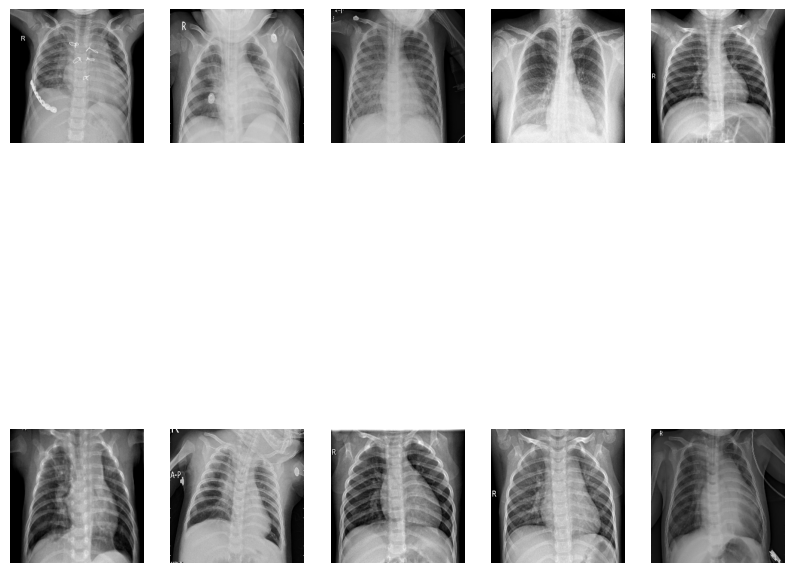

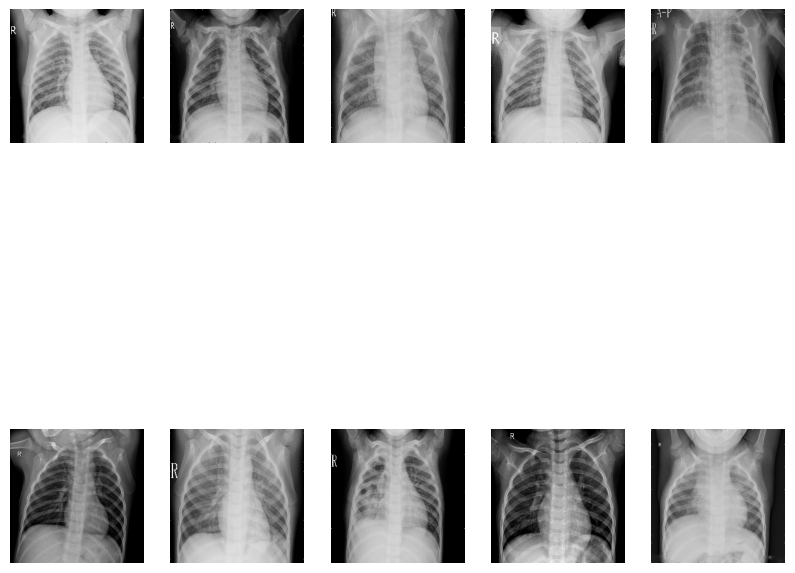

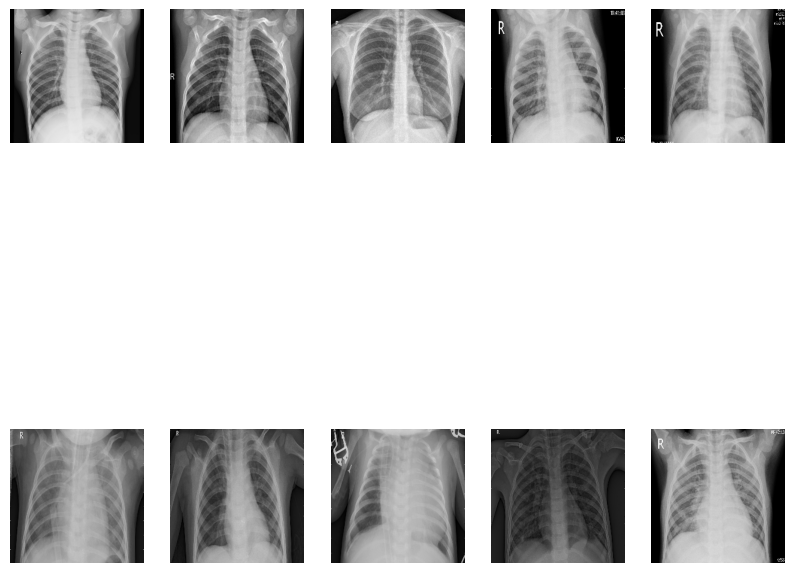

In [3]:
def show_dataset_images(dataset, num_images=10):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # take 1 batch
        for i in range(num_images):
            ax = plt.subplot(2, num_images // 2, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")

# Show images from train set
show_dataset_images(train_ds)

# Show images from validation set
show_dataset_images(val_ds)

# Show images from test set
show_dataset_images(test_ds)


 ## **Normalizing:**
 We normalize the image pixel values from the range [0, 255] to [0, 1] using a Rescaling layer.

This helps the model train faster and improves convergence, as neural networks generally perform better with normalized inputs.

We apply this normalization to the training, validation, and test datasets.

In [4]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

 ## **Data Augmentaion:**
 We apply data augmentation to the training dataset to increase dataset diversity and help the model generalize better.

The augmentation includes:

*   Random horizontal flips
*   Small random rotations (up to 10%)
*   Random zooms (up to 10%)

Note: Augmentation is applied only to the training set, not to validation or test sets.

In [5]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])
train_ds=train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


 ## **Just counting files in folder:**

In [6]:
import os

def count_files_in_folder(folder_path):
    counts = {}
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            counts[class_name] = len(os.listdir(class_folder))
    return counts

train_counts = count_files_in_folder(train_dir)
val_counts = count_files_in_folder(val_dir)
test_counts = count_files_in_folder(test_dir)

print("Train class distribution:", train_counts)
print("Validation class distribution:", val_counts)
print("Test class distribution:", test_counts)


Train class distribution: {'PNEUMONIA': 3875, 'NORMAL': 1341}
Validation class distribution: {'PNEUMONIA': 8, 'NORMAL': 8}
Test class distribution: {'PNEUMONIA': 390, 'NORMAL': 234}


 ## **Building Nueral Network:**
 We define a simple CNN for binary classification (Normal vs Pneumonia).

Architecture:

*   Conv2D + MaxPooling2D layers: Extract spatial features from images
*   Flatten layer: Convert 2D feature maps into a 1D vector
*   Dense layers: Learn higher-level representations
*   Output layer: 2 neurons with softmax for binary classification

Input images are 224x224 with 3 channels (RGB).

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## **Compile and Train the Model**
We compile the CNN using:



*   **Optimizer**: Adam for efficient gradient-based optimization
*   **Loss**: sparse_categorical_crossentropy (suitable for integer labels in multi-class or binary classification)
* **Metric**: accuracy to evaluate performanc



Metric: accuracy to evaluate performance

Then, we train the model on the training dataset for 5 epochs, while monitoring performance on the validation dataset.

In [8]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 504ms/step - accuracy: 0.7327 - loss: 1.0603 - val_accuracy: 0.7500 - val_loss: 0.6652
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 465ms/step - accuracy: 0.8972 - loss: 0.2464 - val_accuracy: 0.6250 - val_loss: 1.1487
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 469ms/step - accuracy: 0.9025 - loss: 0.2361 - val_accuracy: 0.8125 - val_loss: 0.5025
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 466ms/step - accuracy: 0.9347 - loss: 0.1773 - val_accuracy: 0.7500 - val_loss: 0.9137
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 467ms/step - accuracy: 0.9358 - loss: 0.1632 - val_accuracy: 0.7500 - val_loss: 0.7408


* The model quickly learns the training data, reaching a high training accuracy of ~92.5% by epoch 5.

* Validation accuracy fluctuates (56–81%), indicating potential overfitting—the model performs very well on training data but not consistently on validation data.

* Validation loss also varies, further suggesting the model may struggle to generalize.

## **Evaluate Model on Test Set**
Evaluate Model on Test Set

After training, we evaluate the model on the test dataset to measure its generalization performance.

* Test Accuracy: 83%

* Test Loss: 0.396

Interpretation:
The model achieves good performance on unseen data, confirming it has learned useful features. However, the gap between training accuracy (~92.5%) and test accuracy (~83%) suggests some overfitting, which could be improved with more data, stronger augmentation, or regularization.

In [9]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.7918 - loss: 0.5563
Test Accuracy: 0.79


## **Classification Report and Confusion Matrix**
We evaluate the model in more detail using precision, recall, F1-score, and a confusion matrix on the test dataset.

Observations:

* The model performs better at detecting Pneumonia (recall 0.75) than Normal cases (recall 0.22).

* Precision is also higher for Pneumonia, indicating the model is more confident when predicting Pneumonia.

* Overall accuracy drops to 55%, much lower than what we saw during training/testing with .evaluate().

Interpretation:

* The model seems biased towards the Pneumonia class, possibly due to class imbalance in the dataset (more Pneumonia images than Normal).

 1. Improvements could include:

 2. Balancing the dataset (oversampling, undersampling, or class weights)

* Using more advanced CNN architectures (like transfer learning with pretrained models)

Applying stronger regularization or data augmentation

This analysis shows that while the model learns features, its performance on the minority class (Normal) is poor, highlighting the need for careful dataset handling and model tuning.

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step
              precision    recall  f1-score   support

      NORMAL       0.44      0.20      0.27       234
   PNEUMONIA       0.64      0.84      0.73       390

    accuracy                           0.60       624
   macro avg       0.54      0.52      0.50       624
weighted avg       0.56      0.60      0.56       624



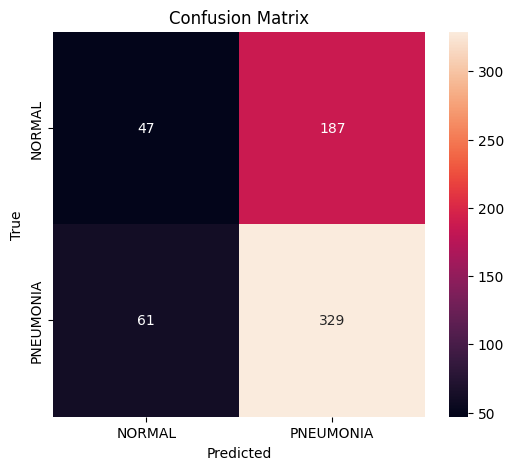

In [10]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels and predictions from test_ds
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)  # for softmax output

# Classification report
print(classification_report(y_true, y_pred, target_names=train_class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=train_class_names, yticklabels=train_class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


## **Training and Validation Curves**
We visualize the model's performance during training:

* Accuracy Curve: Shows how training and validation accuracy evolve over epochs.

* Loss Curve: Shows how training and validation loss change over epochs.

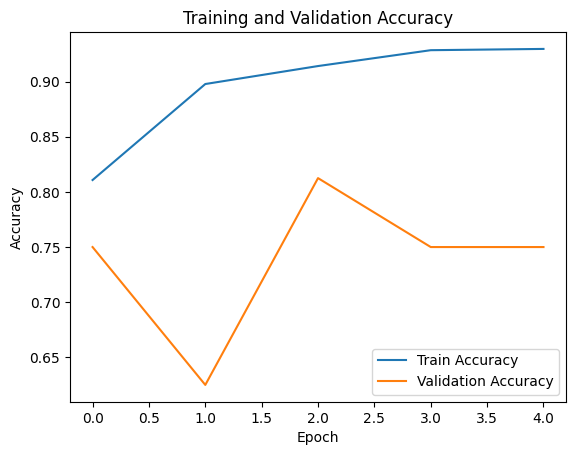

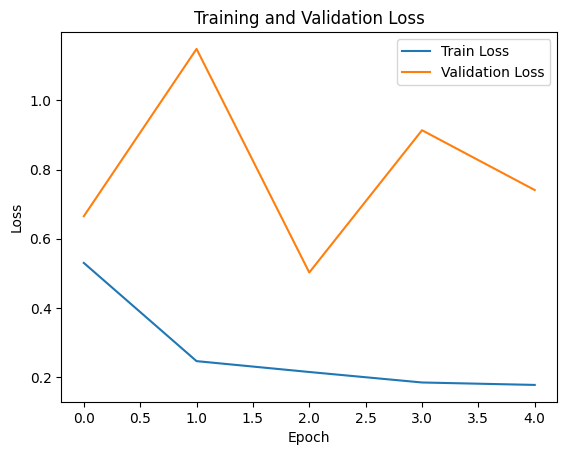

In [11]:
# Plot accuracy curves
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss curves
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Training accuracy (blue line): steadily increases, reaching over 90%, confirming strong learning on training data.

Validation accuracy (orange line):
Initially increases but then drops sharply around epoch 2

model is overfitting: it fits the training data very well but struggles to generalize on validation data, especially around epoch 2.